# Linear Regression

This notebook aims at visualizing the process of fitting a linear regression into some data (that is, a line that passes as close as possible to each point in the dataset), specifically:
    
* Visualize the data
* Visualize the loss function (least squares)
* Visualize the loss function in terms of the fitted line ($w_0 + w_1 x$)
* Visualize the gradient
* Visualize the descend path along the gradient

In [1]:
%matplotlib notebook 
%config InlineBackend.figure_formats=('svg','retina','png')

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

try:
    import seaborn as sns
except:
    pass

import fancy_plot

# Data

Sinus of the form:

$$y = f(u) = sin(\dfrac{1}{2} (5.3 u - 2.1))$$

With added noise:

$$\tilde{y} = \tilde{f}(u) = sin(\dfrac{1}{2} (5.3 u - 2.1)) + \epsilon$$

$$\epsilon \sim N(0, 0.5)$$

In [2]:
xx = np.random.sample(200)
data = np.sin(0.5 * (5.3 * xx - 2.1)) + 0.25 * np.random.normal(scale=0.5, size=200)

data_x = np.hstack((np.ones((xx.shape[0], 1)), xx.reshape((-1, 1))))
data_y = data.reshape((-1,1))
print data_x[0:2]
print data_y[0:2]

[[ 1.          0.05929805]
 [ 1.          0.16462683]]
[[-0.79648871]
 [-0.62493671]]


#### Plot the data points

<IPython.core.display.Javascript object>


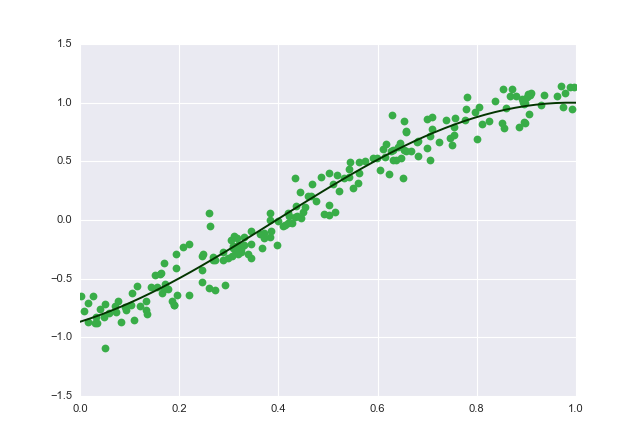

In [3]:
fig = plt.figure()
plt.plot(xx, data_y.ravel(), color=fancy_plot.color('medium green'), marker='o', ls='')

u = np.linspace(0, 1)
plt.plot(u, np.sin(0.5 * (5.3 * u - 2.1)), color=fancy_plot.color('dark green'))

In [4]:
def get_scaled(x):
    x_scaled = x.copy()
#     x_scaled[:, 1:] = (x[:, 1:] - x[:, 1:].mean(axis=0)) / np.std(x[:, 1:], axis=0)
    return x_scaled

get_scaled(data_x)

array([[ 1.        ,  0.05929805],
       [ 1.        ,  0.16462683],
       [ 1.        ,  0.36365027],
       [ 1.        ,  0.47614757],
       [ 1.        ,  0.91027734],
       [ 1.        ,  0.19323253],
       [ 1.        ,  0.05124294],
       [ 1.        ,  0.50194965],
       [ 1.        ,  0.89789908],
       [ 1.        ,  0.40883339],
       [ 1.        ,  0.70025916],
       [ 1.        ,  0.0023924 ],
       [ 1.        ,  0.04780483],
       [ 1.        ,  0.45353589],
       [ 1.        ,  0.42229798],
       [ 1.        ,  0.56067996],
       [ 1.        ,  0.24816378],
       [ 1.        ,  0.50106104],
       [ 1.        ,  0.3314994 ],
       [ 1.        ,  0.4591664 ],
       [ 1.        ,  0.0259251 ],
       [ 1.        ,  0.0153884 ],
       [ 1.        ,  0.31856211],
       [ 1.        ,  0.85285781],
       [ 1.        ,  0.8501228 ],
       [ 1.        ,  0.43786549],
       [ 1.        ,  0.75317969],
       [ 1.        ,  0.90548263],
       [ 1.        ,

## Least squares function

$$f(x) = x^2$$

$$L = \sum_{x_i, y_i} (y_i - \hat{y_i})^2 = \sum_{x_i, y_i} (y_i - w^Tx_i)^2$$

To simplify the derivative, we will instead take:

$$f(x) = \dfrac{1}{2} x^2 \rightarrow L = \dfrac{1}{2} \sum_{x_i, y_i} (y_i - w^Tx_i)^2$$

In [5]:
def norm(x):
    return 0.5 * (x**2).sum(axis=1)

def lse(x, y, w):
    return 0.5 * ((y - x.dot(w))**2).sum()

<IPython.core.display.Javascript object>


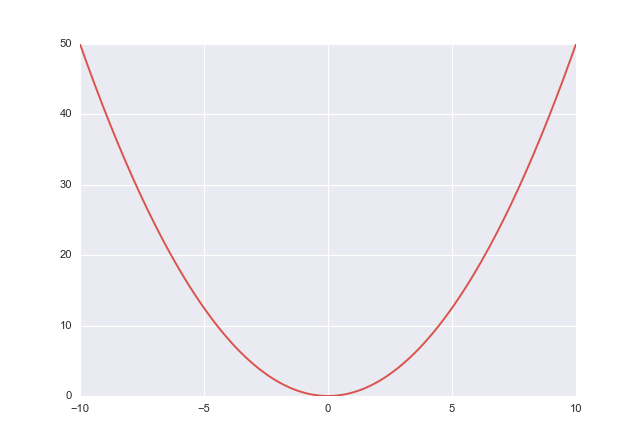

In [6]:
u = np.linspace(-10, 10, 200)
fig = plt.figure()
gca = fig.gca()
plt.plot(u, norm(u.reshape((-1, 1))), fancy_plot.color('pale red'))

2.25758095065


<IPython.core.display.Javascript object>


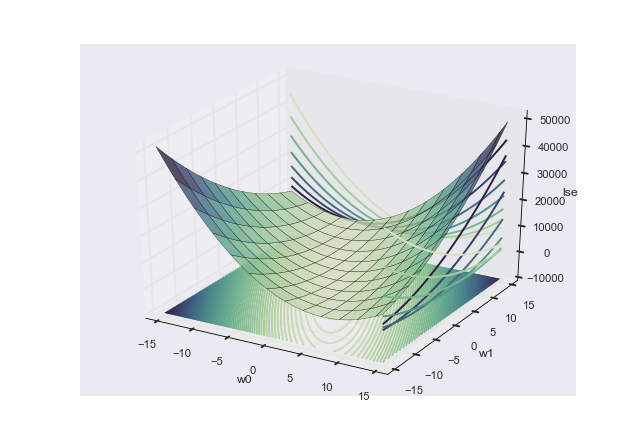

In [7]:
from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets

def plot_lse():
    w0_limits = -15, 15
    w1_limits = -15, 15
    w0 = np.linspace(*w0_limits,num=100)
    w1 = np.linspace(*w1_limits,num=100)

    x_scaled = get_scaled(data_x)

    zs = [lse(x_scaled, data_y, np.asarray((w0_i, w1_i)).reshape((-1, 1))) for w1_i in w1 for w0_i in w0]

    w0, w1 = np.meshgrid(w0, w1)
    Z = np.asarray(zs).reshape(w1.shape)
    print Z.min()

    cmap = fancy_plot.cubhelix(8, start=.5, rot=-.75, as_cmap=True)
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    ax.plot_surface(w0, w1, Z, cstride=8, alpha=0.8, cmap=cmap)
    cset = ax.contour(w0, w1, Z, 100, zdir='z', offset=-1e4, cmap=cmap)
    cset = ax.contour(w0, w1, Z, zdir='x', offset=w0_limits[1], cmap=cmap)
    cset = ax.contour(w0, w1, Z, zdir='y', offset=w1_limits[1], cmap=cmap)

    ax.set_xlabel('w0')
    ax.set_xlim(w0_limits[0] - 1, w0_limits[1] + 1)
    ax.set_ylabel('w1')
    ax.set_ylim(w1_limits[0] - 1, w1_limits[1] + 1)
    ax.set_zlabel('lse')
    ax.set_zlim((-1e4, Z.max()))
    
    plt.show()
    
plot_lse()

## LSE Gradient

$$\dfrac{\delta L}{\delta w} = -(y - w^Tx) x^T$$

In [8]:
def lse_gradient(x, y, w):
    yhat = x.dot(w)
    return -x.T.dot(y - yhat)

### Visualization of the gradient

Given $w_0$ fixed, visualize the direction of the gradient ($\nabla L = \dfrac{\delta L}{\delta w}$)

<IPython.core.display.Javascript object>


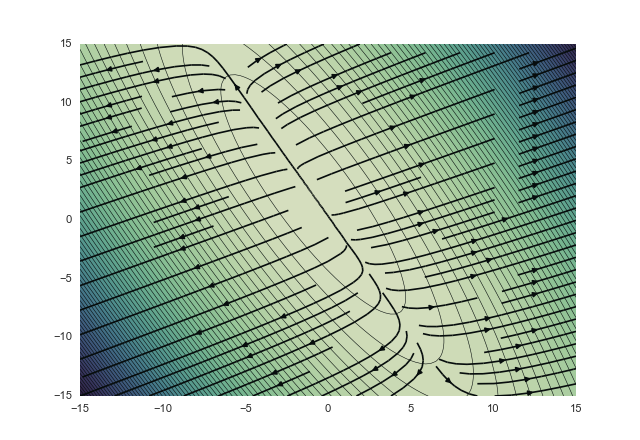

51657.6335147


In [9]:
from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets

def plot_lse_gradient():    
    w0_limits = -15, 15
    w1_limits = -15, 15
    w0 = np.linspace(*w0_limits,num=100)
    w1 = np.linspace(*w1_limits,num=100)

    x_scaled = get_scaled(data_x)

    zs = [lse(x_scaled, data_y, np.asarray((w0_i, w1_i)).reshape((-1, 1))) for w1_i in w1 for w0_i in w0]
    gs = [lse_gradient(x_scaled, data_y, np.asarray((w0_i, w1_i)).reshape((-1, 1))) for w1_i in w1 for w0_i in w0]
    
    w0, w1 = np.meshgrid(w0, w1)
    Z = np.asarray(zs).reshape(w1.shape)
    G = np.asanyarray(gs)

    cmap = fancy_plot.cubhelix(8, start=.5, rot=-.75, as_cmap=True)
    fig = plt.figure()
    ax = fig.gca()
    ax.contourf(w0, w1, Z, 80, zdir='z', offset=Z.min(), cmap=cmap)
    lines = ax.contour(w0, w1, Z, 80, zdir='z', offset=Z.min())
    ax.streamplot(w0, w1, G[:, 0].reshape(w1.shape), G[:, 1].reshape(w1.shape), 1, color=fancy_plot.color('almost black'), linewidth=1.5)

    for l in lines.collections:
        l.set_linewidth(0.5)
        l.set_color(fancy_plot.color('almost black'))
    
    plt.show()
    
    print Z.max()
    
plot_lse_gradient()

## Gradient descend

In [10]:
neg = lambda f: lambda *args: -f(*args)

def gradient_descend(x, y, f, grad, steps=5000, lr=1, lr_epsilon=1e-6, epsilon=1e-6, fix_w0=None):
    lr_0 = lr
    w_0 = np.random.sample((x.shape[1], 1)) * 10
#     w_0 = np.ones((x.shape[1], 1)) * 10

    if fix_w0 is not None:
        w_0[0, 0] = fix_w0
            
    path = [w_0]
    obj = [f(x, y, w_0)]
    
    s = 0
    alpha = 1
    while s < steps and lr >= lr_epsilon and alpha >= epsilon:
        w_1 = w_0 - lr * grad(x, y, w_0)
        
        if fix_w0 is not None:
            w_1[0, 0] = fix_w0
        
        loss = f(x, y, w_1)
        if loss < obj[-1]:
            alpha = np.linalg.norm(w_0 - w_1)
            lr = lr_0
            w_0 = w_1
            path += [w_0]
            obj += [loss]
            s += 1
        else:
            lr = lr * 0.5
        
    return w_0, np.array(path), np.array(obj)

## Plotting

In [11]:
def plot_gradiend_descend(f, grad, w, path):
    plt.figure()
    plt.plot(obj, lw=2.5)
    plt.show()

    fig = plt.figure()
    ax = fig.gca()

    w0_limits = min(-15, path[:,0].min() - 1), max(15, path[:,0].max() + 1)
    w1_limits = min(-15, path[:,1].min() - 1), max(15, path[:,1].max() + 1)
    w0 = np.linspace(*w0_limits,num=100)
    w1 = np.linspace(*w1_limits,num=100)

    x_scaled = get_scaled(data_x)

    zs = [f(x_scaled, data_y, np.asarray((w0_i, w1_i)).reshape((-1, 1))) for w1_i in w1 for w0_i in w0]
    gs = [grad(x_scaled, data_y, np.asarray((w0_i, w1_i)).reshape((-1, 1))) for w1_i in w1 for w0_i in w0]

    w0, w1 = np.meshgrid(w0, w1)
    Z = np.asarray(zs).reshape(w1.shape)
    G = np.asanyarray(gs)

    ax.plot(path[:, 0], path[:, 1], fancy_plot.color('dark blue'), lw=2.5)
    ax.plot(path[0, 0], path[0, 1], fancy_plot.color('pale red'), marker='o', markersize=10, markeredgecolor='white')
    ax.plot(path[-1, 0], path[-1, 1], fancy_plot.color('frog green'), marker='o', markersize=10, markeredgecolor='white')

    cmap = fancy_plot.cubhelix(8, start=.5, rot=-.75, as_cmap=True)
    ax.contourf(w0, w1, Z, 80, zdir='z', offset=Z.min(), cmap=cmap)
    lines = ax.contour(w0, w1, Z, 80, zdir='z', offset=Z.min())
    ax.streamplot(w0, w1, G[:, 0].reshape(w1.shape), G[:, 1].reshape(w1.shape), 1, color=fancy_plot.color('almost black'), linewidth=1.5)

    for l in lines.collections:
        l.set_linewidth(0.5)
        l.set_color(fancy_plot.color('almost black'))
    
    plt.show()

## Do some tests

Done optimizing in 243 steps
Found w: [[-0.89407238]
 [ 2.18090931]]


<IPython.core.display.Javascript object>


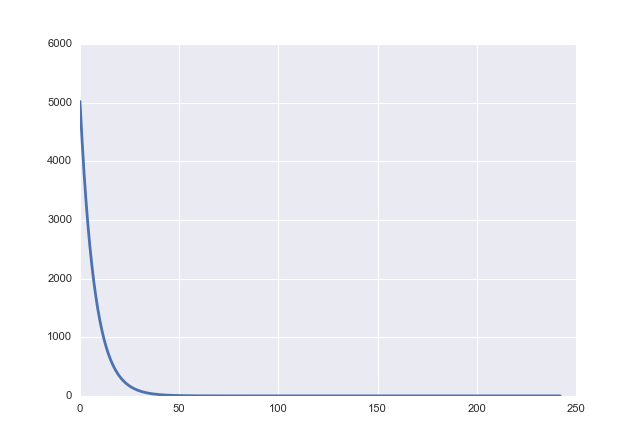

<IPython.core.display.Javascript object>


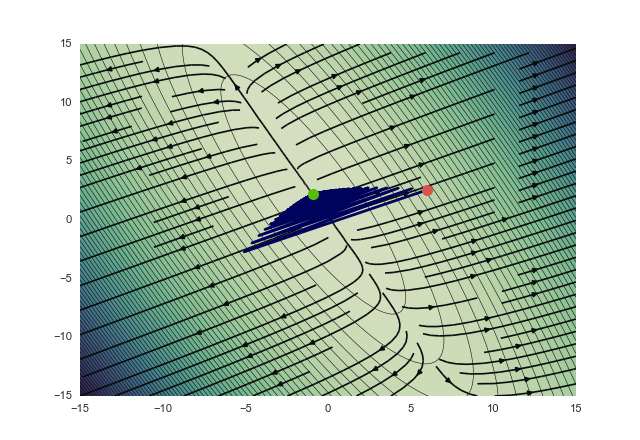

In [12]:
w, path, obj = gradient_descend(get_scaled(data_x), data_y, lse, lse_gradient)

print "Done optimizing in %d steps" % (len(path),)
print "Found w:", w

plot_gradiend_descend(lse, lse_gradient, w, path)

## Final regression

<IPython.core.display.Javascript object>


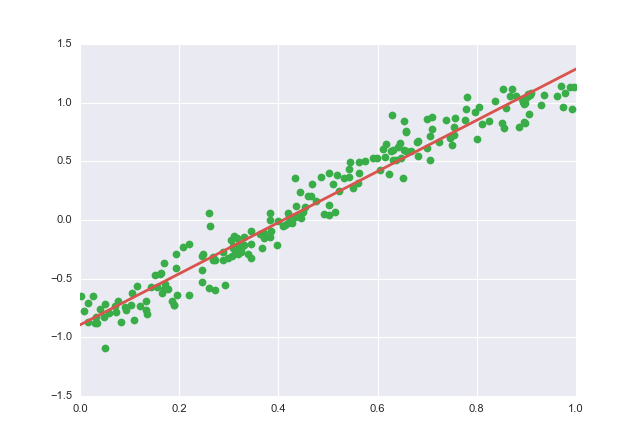

In [13]:
fig = plt.figure()
plt.plot(xx, data_y.ravel(), color=fancy_plot.color('medium green'), marker='o', ls='')

u = np.linspace(0, 1)
uhat = np.hstack((np.ones((u.shape[0], 1)), u.reshape((-1, 1))))
yhat = uhat.dot(w)
plt.plot(u, yhat, color=fancy_plot.color('pale red'), lw=2.5)